In [2]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy
from sklearn import svm
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

import random
from itertools import product

In [3]:
X = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/X.npy');
y = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/y.npy');
print "%s" %(X.shape,);
print "%s" %(y.shape,);
raw_data = zip(X, y);
print type(raw_data);

(188118, 4200)
(188118,)
<type 'list'>


In [4]:
data = [];
n_classSample = 1000; # Number of samples from each class
for i in range(0, 10):
    data_for_class = [x for x in raw_data if x[1] == i];
    data = data + random.sample(data_for_class, n_classSample);
# data is a list of (ndarray, int)
random.shuffle(data);
quota = 0.75;
n_training = int(len(data) * quota);
n_testing = len(data) - n_training;

In [5]:
training_data = data[:n_training];
testing_data = data[n_training:];

In [6]:
training_X = np.asarray([x[0] for x in training_data]);
training_y = np.asarray([x[1] for x in training_data]);
testing_X = np.asarray([x[0] for x in testing_data]);
testing_y = np.asarray([x[1] for x in testing_data]);

In [7]:
print "Shape of training data: %s" %(training_X.shape,);
print "Shape of training label: %s" %(training_y.shape,);
print "Shape of testing data: %s" %(testing_X.shape,);
print "Shape of testing label: %s" %(testing_y.shape,);

Shape of training data: (7500, 4200)
Shape of training label: (7500,)
Shape of testing data: (2500, 4200)
Shape of testing label: (2500,)


In [8]:
# Train in parallel.
def train_job(position):
    i = position[0];
    j = position[1];
    xi = training_X[i];
    xj = training_X[j];
    hi = 0.5 * sum(xi + xj - np.absolute(xi - xj)); # Equals to min(xi, xj)
    return (i*n_training + j, hi);

positions = [(x[0], x[1]) for x in product(range(0, n_training),range(0, n_training))];
start = time();
pool = Pool(processes=8); # This is a compution-heavy work, so we can have more process, like 15.
result = pool.map(train_job, positions);
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 3648.45438313 sec.


In [9]:
sorted(result, key=lambda x: x[0]);
myKernel = np.asarray([v[1] for v in result]);
myKernel = myKernel.reshape(n_training, n_training);

In [10]:
# Train SVM
clf = svm.SVC(kernel="precomputed", decision_function_shape='ovr');
clf.fit(myKernel, training_y);

In [11]:
# Training accuracy
predict_labels_train = clf.predict(myKernel);
n_correct_train = 0;
for i in range(len(training_data)):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / len(training_data));

Training accuracy: 0.892666666667


In [12]:
cm_train = confusion_matrix(training_y, predict_labels_train);

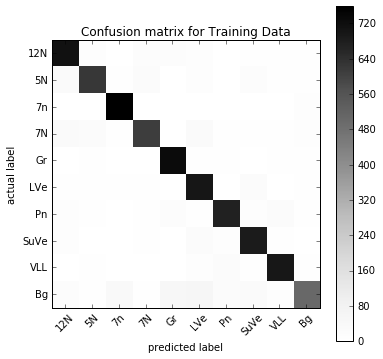

In [13]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Greys);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Training Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);

In [14]:
# Test in paralle.
def test_job(position):
    i = position[0];
    j = position[1];
    xi = testing_X[i];
    xj = training_X[j];
    hi = 0.5 * sum(xi + xj - np.absolute(xi - xj)); # Equals to min(xi, xj)
    return (i*n_testing + j, hi);

positions = [(x[0], x[1]) for x in product(range(0, n_testing),range(0, n_training))];
start = time();
pool = Pool(processes=8);
result = pool.map(test_job, positions);
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 1215.09832406 sec.


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/python/lib/python2.7/threading.py", line 551, in __bootstrap_inner
    self.run()
  File "/opt/python/lib/python2.7/threading.py", line 504, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/opt/python/lib/python2.7/multiprocessing/pool.py", line 302, in _handle_workers
    pool._maintain_pool()
  File "/opt/python/lib/python2.7/multiprocessing/pool.py", line 206, in _maintain_pool
    self._repopulate_pool()
  File "/opt/python/lib/python2.7/multiprocessing/pool.py", line 199, in _repopulate_pool
    w.start()
  File "/opt/python/lib/python2.7/multiprocessing/process.py", line 130, in start
    self._popen = Popen(self)
  File "/opt/python/lib/python2.7/multiprocessing/forking.py", line 120, in __init__
    self.pid = os.fork()
OSError: [Errno 12] Cannot allocate memory



In [15]:
sorted(result, key=lambda x: x[0]);
testKernel = np.asarray([v[1] for v in result]);
testKernel = testKernel.reshape(n_testing, n_training);

In [16]:
predict_labels_test = clf.predict(testKernel);
n_correct_test = 0;
for i in range(0, n_testing):
    if (predict_labels_test[i] == testing_y[i]):
        n_correct_test += 1;
print "Test accuracy: {}".format(1.0*n_correct_test / n_testing);

Test accuracy: 0.6104


In [17]:
cm_test = confusion_matrix(testing_y, predict_labels_test);

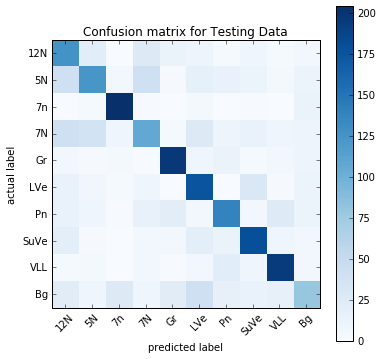

In [18]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Testing Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);